Using device: cuda:0
Epoch [10/400], Train Accuracy: 0.48, Test Accuracy: 0.46
Epoch [20/400], Train Accuracy: 0.55, Test Accuracy: 0.53
Epoch [30/400], Train Accuracy: 0.67, Test Accuracy: 0.69
Epoch [40/400], Train Accuracy: 0.71, Test Accuracy: 0.72
Epoch [50/400], Train Accuracy: 0.77, Test Accuracy: 0.73
Epoch [60/400], Train Accuracy: 0.79, Test Accuracy: 0.76
Epoch [70/400], Train Accuracy: 0.82, Test Accuracy: 0.78


/home/kh/app/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/datasets/_openml.py:303: UserWarning: Multiple active versions of the dataset matching the name vehicle exist. Versions may be fundamentally different, returning version 1.
  warn(
/home/kh/app/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Epoch [80/400], Train Accuracy: 0.83, Test Accuracy: 0.78
Epoch [90/400], Train Accuracy: 0.85, Test Accuracy: 0.78
Epoch [100/400], Train Accuracy: 0.86, Test Accuracy: 0.79
Epoch [110/400], Train Accuracy: 0.87, Test Accuracy: 0.79
Epoch [120/400], Train Accuracy: 0.88, Test Accuracy: 0.79
Epoch [130/400], Train Accuracy: 0.89, Test Accuracy: 0.79
Epoch [140/400], Train Accuracy: 0.90, Test Accuracy: 0.82
Epoch [150/400], Train Accuracy: 0.91, Test Accuracy: 0.84
Epoch [160/400], Train Accuracy: 0.92, Test Accuracy: 0.85
Epoch [170/400], Train Accuracy: 0.92, Test Accuracy: 0.84
Epoch [180/400], Train Accuracy: 0.93, Test Accuracy: 0.86
Epoch [190/400], Train Accuracy: 0.94, Test Accuracy: 0.85
Epoch [200/400], Train Accuracy: 0.95, Test Accuracy: 0.85
Epoch [210/400], Train Accuracy: 0.96, Test Accuracy: 0.85
Epoch [220/400], Train Accuracy: 0.96, Test Accuracy: 0.86
Epoch [230/400], Train Accuracy: 0.97, Test Accuracy: 0.86
Epoch [240/400], Train Accuracy: 0.97, Test Accuracy: 0.86

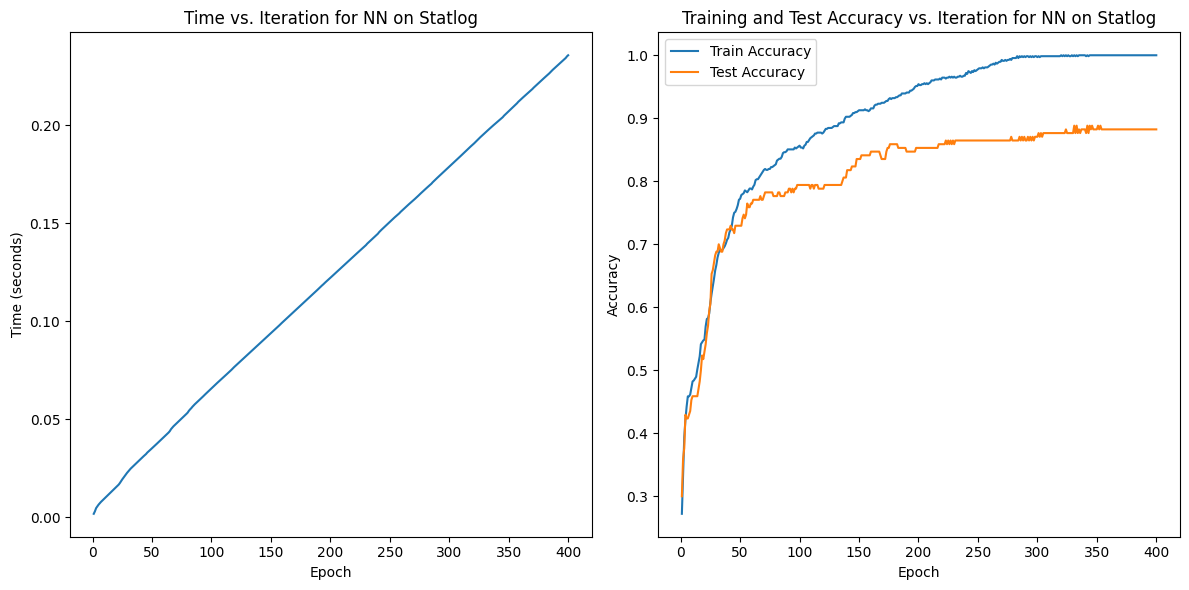

Final Train Accuracy: 1.00
Final Test Accuracy: 0.88


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import fetch_openml
import time

# Check for GPU availability
device = torch.device("cuda:0")
print(f"Using device: {device}")

# Load the Statlog dataset (replace 'statlog_dataset.csv' with your dataset file)
data = fetch_openml("vehicle")

# Extract the features and labels
X = data.data
y = data.target

# Convert target labels to numeric format
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert NumPy arrays to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

# Define a multi-class neural network model
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, num_classes):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Specify the number of classes in your dataset
num_classes = len(np.unique(y))

# Create the neural network model
model = NeuralNetwork(X_train.shape[1], num_classes).to(device)

# Define loss function and optimizer for multi-class classification
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

# Lists to store accuracy and timing data
train_accuracies = []
test_accuracies = []
times = []

# Train the model
num_epochs = 400
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    # Record the start time
    start_time = time.time()
    
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    
    # Record the end time
    end_time = time.time()
    
    # Evaluate the model on the test data
    model.eval()
    with torch.no_grad():
        outputs = model(X_test)
        predictions = torch.argmax(outputs, dim=1)
        test_accuracy = accuracy_score(y_test.cpu().numpy(), predictions.cpu().numpy())
        test_accuracies.append(test_accuracy)
        
        outputs = model(X_train)
        predictions = torch.argmax(outputs, dim=1)
        train_accuracy = accuracy_score(y_train.cpu().numpy(), predictions.cpu().numpy())
        train_accuracies.append(train_accuracy)
        
        lasttime = times[-1] if epoch > 0 else 0
        times.append(lasttime + end_time - start_time)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Accuracy: {train_accuracy:.2f}, Test Accuracy: {test_accuracy:.2f}")

# Plot the time vs. iteration
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), times, label="Time")
plt.xlabel("Epoch")
plt.ylabel("Time (seconds)")
plt.title("Time vs. Iteration for NN on Statlog")

# Plot the accuracy vs. iteration
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label="Train Accuracy")
plt.plot(range(1, num_epochs + 1), test_accuracies, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Test Accuracy vs. Iteration for NN on Statlog")
plt.legend()

plt.tight_layout()
plt.show()

# Final accuracy
print(f"Final Train Accuracy: {train_accuracies[-1]:.2f}")
print(f"Final Test Accuracy: {test_accuracies[-1]:.2f}")


Using device: cuda:0
Epoch [10/400], Train Accuracy: 0.58, Test Accuracy: 0.63
Epoch [20/400], Train Accuracy: 0.63, Test Accuracy: 0.66
Epoch [30/400], Train Accuracy: 0.71, Test Accuracy: 0.69
Epoch [40/400], Train Accuracy: 0.76, Test Accuracy: 0.72
Epoch [50/400], Train Accuracy: 0.79, Test Accuracy: 0.75
Epoch [60/400], Train Accuracy: 0.80, Test Accuracy: 0.78
Epoch [70/400], Train Accuracy: 0.81, Test Accuracy: 0.78


/home/kh/app/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/datasets/_openml.py:303: UserWarning: Multiple active versions of the dataset matching the name vehicle exist. Versions may be fundamentally different, returning version 1.
  warn(
/home/kh/app/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Epoch [80/400], Train Accuracy: 0.82, Test Accuracy: 0.79
Epoch [90/400], Train Accuracy: 0.83, Test Accuracy: 0.80
Epoch [100/400], Train Accuracy: 0.84, Test Accuracy: 0.78
Epoch [110/400], Train Accuracy: 0.85, Test Accuracy: 0.81
Epoch [120/400], Train Accuracy: 0.86, Test Accuracy: 0.82
Epoch [130/400], Train Accuracy: 0.88, Test Accuracy: 0.83
Epoch [140/400], Train Accuracy: 0.89, Test Accuracy: 0.83
Epoch [150/400], Train Accuracy: 0.89, Test Accuracy: 0.83
Epoch [160/400], Train Accuracy: 0.89, Test Accuracy: 0.82
Epoch [170/400], Train Accuracy: 0.91, Test Accuracy: 0.84
Epoch [180/400], Train Accuracy: 0.92, Test Accuracy: 0.84
Epoch [190/400], Train Accuracy: 0.92, Test Accuracy: 0.85
Epoch [200/400], Train Accuracy: 0.93, Test Accuracy: 0.85
Epoch [210/400], Train Accuracy: 0.94, Test Accuracy: 0.86
Epoch [220/400], Train Accuracy: 0.94, Test Accuracy: 0.86
Epoch [230/400], Train Accuracy: 0.94, Test Accuracy: 0.87
Epoch [240/400], Train Accuracy: 0.95, Test Accuracy: 0.87

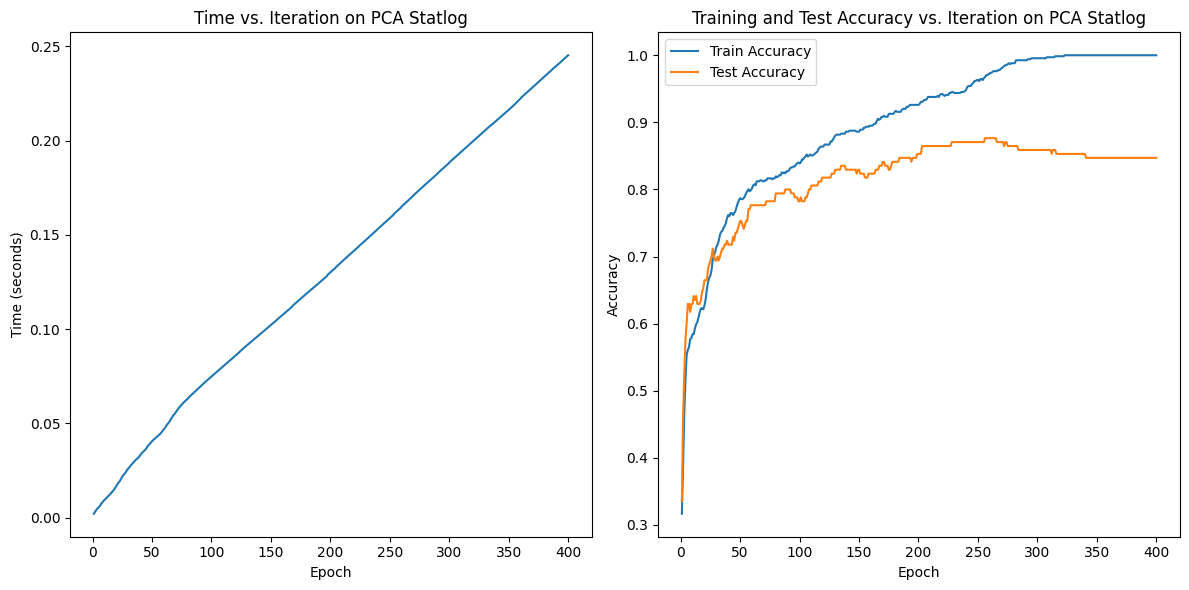

Total Training Time: 0.25 seconds
Final Train Accuracy: 1.00
Final Test Accuracy: 0.85


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import fetch_openml
import time

# Check for GPU availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load the Statlog dataset (replace 'statlog_dataset.csv' with your dataset file)
data = fetch_openml("vehicle")

# Extract the features and labels
X = data.data
y = data.target

# Convert target labels to numeric format
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Perform dimensionality reduction with power iteration (PCA)
from sklearn.decomposition import PCA

# Set the desired number of components
n_components = 14  # You can adjust this as needed

# Fit PCA to the training data
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Convert NumPy arrays to PyTorch tensors
X_train_pca = torch.tensor(X_train_pca, dtype=torch.float32).to(device)
X_test_pca = torch.tensor(X_test_pca, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

# Define a neural network model
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, num_classes):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Specify the number of classes in your dataset
num_classes = len(np.unique(y))

# Create the neural network model
model = NeuralNetwork(X_train_pca.shape[1], num_classes).to(device)

# Define loss function and optimizer for multi-class classification
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

# Lists to store accuracy and timing data
train_accuracies = []
test_accuracies = []
times = []
total_training_time = 0.0  # To track the total training time

# Train the model
num_epochs = 400
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    # Record the start time
    start_time = time.time()
    
    outputs = model(X_train_pca)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    
    # Record the end time
    end_time = time.time()
    
    total_training_time += end_time - start_time  # Add the epoch training time to the total
    times.append(total_training_time)
    
    # Evaluate the model on the test data
    model.eval()
    with torch.no_grad():
        outputs = model(X_test_pca)
        predictions = torch.argmax(outputs, dim=1)
        test_accuracy = accuracy_score(y_test.cpu().numpy(), predictions.cpu().numpy())
        test_accuracies.append(test_accuracy)
        
        outputs = model(X_train_pca)
        predictions = torch.argmax(outputs, dim=1)
        train_accuracy = accuracy_score(y_train.cpu().numpy(), predictions.cpu().numpy())
        train_accuracies.append(train_accuracy)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Accuracy: {train_accuracy:.2f}, Test Accuracy: {test_accuracy:.2f}")

# Plot the time vs. iteration
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), times, label="Time")
plt.xlabel("Epoch")
plt.ylabel("Time (seconds)")
plt.title("Time vs. Iteration on PCA Statlog")

# Plot the accuracy vs. iteration
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label="Train Accuracy")
plt.plot(range(1, num_epochs + 1), test_accuracies, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Test Accuracy vs. Iteration on PCA Statlog")
plt.legend()

plt.tight_layout()
plt.show()

# Total training time
print(f"Total Training Time: {total_training_time:.2f} seconds")

# Final accuracy
print(f"Final Train Accuracy: {train_accuracies[-1]:.2f}")
print(f"Final Test Accuracy: {test_accuracies[-1]:.2f}")


Using device: cuda:0


/home/kh/app/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/datasets/_openml.py:303: UserWarning: Multiple active versions of the dataset matching the name vehicle exist. Versions may be fundamentally different, returning version 1.
  warn(
/home/kh/app/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Epoch [10/400], Train Accuracy: 0.54, Test Accuracy: 0.15
Epoch [20/400], Train Accuracy: 0.58, Test Accuracy: 0.16
Epoch [30/400], Train Accuracy: 0.60, Test Accuracy: 0.18
Epoch [40/400], Train Accuracy: 0.62, Test Accuracy: 0.21
Epoch [50/400], Train Accuracy: 0.64, Test Accuracy: 0.18
Epoch [60/400], Train Accuracy: 0.66, Test Accuracy: 0.17
Epoch [70/400], Train Accuracy: 0.67, Test Accuracy: 0.17
Epoch [80/400], Train Accuracy: 0.66, Test Accuracy: 0.17
Epoch [90/400], Train Accuracy: 0.69, Test Accuracy: 0.16
Epoch [100/400], Train Accuracy: 0.69, Test Accuracy: 0.16
Epoch [110/400], Train Accuracy: 0.69, Test Accuracy: 0.16
Epoch [120/400], Train Accuracy: 0.70, Test Accuracy: 0.16
Epoch [130/400], Train Accuracy: 0.70, Test Accuracy: 0.16
Epoch [140/400], Train Accuracy: 0.71, Test Accuracy: 0.16
Epoch [150/400], Train Accuracy: 0.72, Test Accuracy: 0.15
Epoch [160/400], Train Accuracy: 0.73, Test Accuracy: 0.15
Epoch [170/400], Train Accuracy: 0.74, Test Accuracy: 0.15
Epoch 

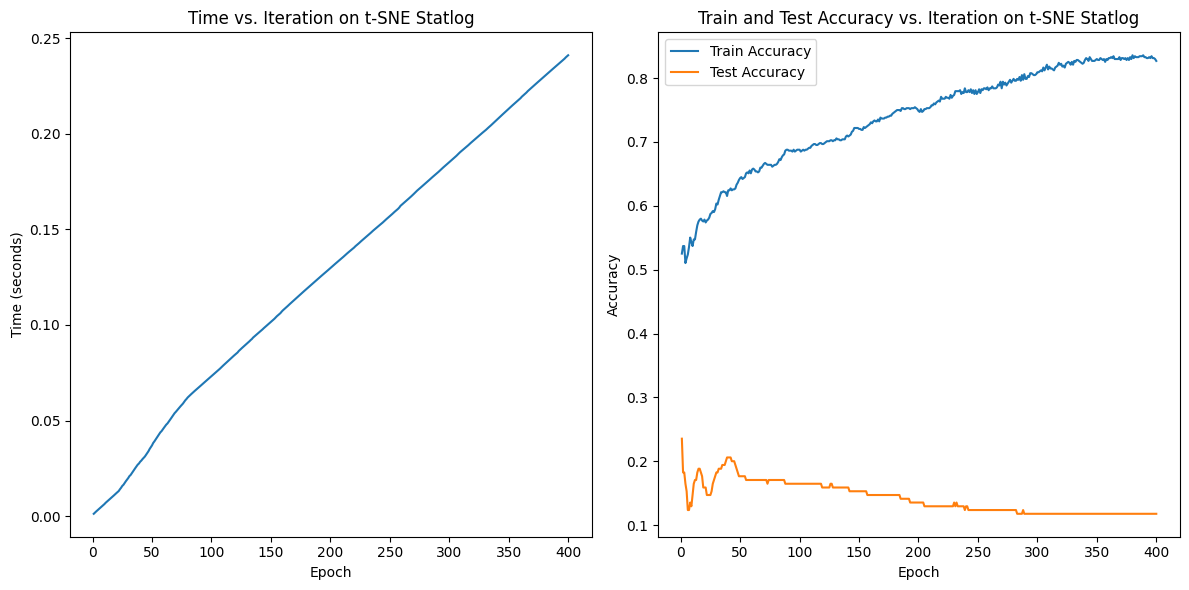

Total Training Time: 0.24 seconds
Final Train Accuracy: 0.83
Final Test Accuracy: 0.12


In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import fetch_openml
from sklearn.manifold import TSNE
import time

# Check for GPU availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load the Statlog dataset (replace 'statlog_dataset.csv' with your dataset file)
data = fetch_openml("vehicle")

# Extract the features and labels
X = data.data
y = data.target

# Convert target labels to numeric format
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Perform dimensionality reduction with t-SNE
n_components = 3  # Set the desired number of components (2D for visualization)
tsne = TSNE(n_components=n_components)
X_train_tsne = tsne.fit_transform(X_train)
X_test_tsne = tsne.fit_transform(X_test)  # Use transform to project the test data

# Convert NumPy arrays to PyTorch tensors
X_train_tsne = torch.tensor(X_train_tsne, dtype=torch.float32).to(device)
X_test_tsne = torch.tensor(X_test_tsne, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

# Define a neural network model
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, num_classes):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Specify the number of classes in your dataset
num_classes = len(np.unique(y))

# Create the neural network model
model = NeuralNetwork(X_train_tsne.shape[1], num_classes).to(device)

# Define loss function and optimizer for multi-class classification
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

# Lists to store accuracy and timing data
train_accuracies = []
test_accuracies = []
times = []
total_training_time = 0.0  # To track the total training time

# Train the model
num_epochs = 400
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    # Record the start time
    start_time = time.time()
    
    outputs = model(X_train_tsne)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    
    # Record the end time
    end_time = time.time()
    
    total_training_time += end_time - start_time  # Add the epoch training time to the total
    times.append(total_training_time)
    
    # Evaluate the model on the test data
    model.eval()
    with torch.no_grad():
        outputs = model(X_test_tsne)
        predictions = torch.argmax(outputs, dim=1)
        test_accuracy = accuracy_score(y_test.cpu().numpy(), predictions.cpu().numpy())
        test_accuracies.append(test_accuracy)
        
        outputs = model(X_train_tsne)
        predictions = torch.argmax(outputs, dim=1)
        train_accuracy = accuracy_score(y_train.cpu().numpy(), predictions.cpu().numpy())
        train_accuracies.append(train_accuracy)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Accuracy: {train_accuracy:.2f}, Test Accuracy: {test_accuracy:.2f}")

# Plot the time vs. iteration
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), times, label="Time")
plt.xlabel("Epoch")
plt.ylabel("Time (seconds)")
plt.title("Time vs. Iteration on t-SNE Statlog")

# Plot the accuracy vs. iteration
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label="Train Accuracy")
plt.plot(range(1, num_epochs + 1), test_accuracies, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train and Test Accuracy vs. Iteration on t-SNE Statlog")
plt.legend()

plt.tight_layout()
plt.show()

# Total training time
print(f"Total Training Time: {total_training_time:.2f} seconds")

# Final accuracy
print(f"Final Train Accuracy: {train_accuracies[-1]:.2f}")
print(f"Final Test Accuracy: {test_accuracies[-1]:.2f}")


Using device: cuda:0


/home/kh/app/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/datasets/_openml.py:303: UserWarning: Multiple active versions of the dataset matching the name vehicle exist. Versions may be fundamentally different, returning version 1.
  warn(
/home/kh/app/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


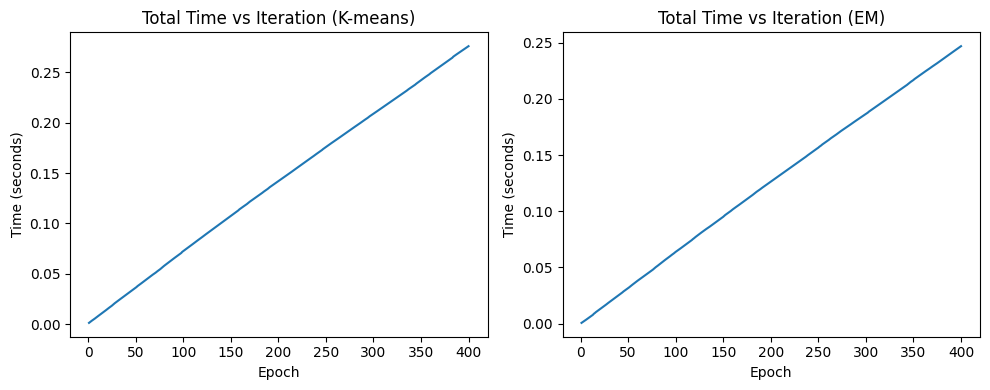

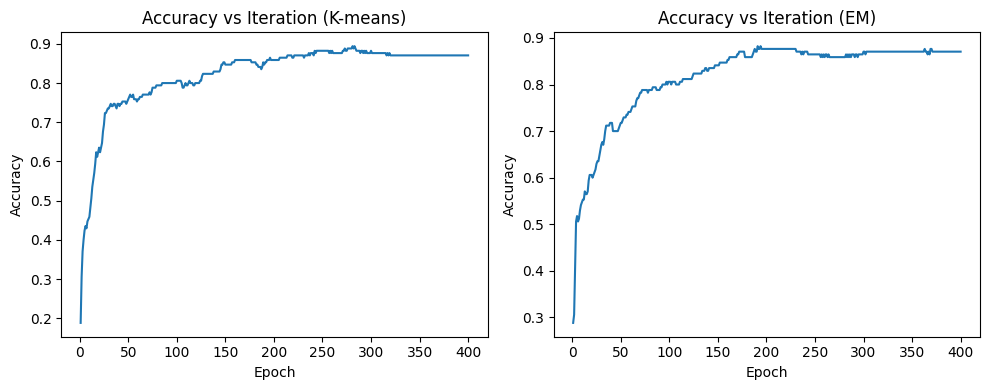

best accuracy for kmeans is  0.8941176470588236
best accuracy for em is  0.8823529411764706


In [70]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import fetch_openml
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import time
import matplotlib.pyplot as plt

# Check for GPU availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load the Statlog dataset (replace 'statlog_dataset.csv' with your dataset file)
data = fetch_openml("vehicle")

# Extract the features and labels
X = data.data
y = data.target

# Convert target labels to numeric format
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Perform K-means clustering and EM (Expectation-Maximization) clustering
n_clusters = 12  # Number of clusters for K-means and EM

# Create empty lists to store results
times_kmeans = []
accuracies_kmeans = []
times_em = []
accuracies_em = []

# Define a neural network model
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, num_classes):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Specify the number of classes in your dataset
num_classes = len(np.unique(y))

# Create two neural network models for K-means and EM features
model_kmeans = NeuralNetwork(X_train.shape[1], num_classes).to(device)
model_em = NeuralNetwork(X_train.shape[1], num_classes).to(device)

# Define loss function and optimizer for multi-class classification
criterion = nn.CrossEntropyLoss()
optimizer_kmeans = optim.Adam(model_kmeans.parameters(), lr=0.001,weight_decay=0.0001)
optimizer_em = optim.Adam(model_em.parameters(), lr=0.001,weight_decay= 0.0001)

# Convert NumPy arrays to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

# Train the models for K-means and EM features
num_epochs = 400
total_time_em = 0.0
total_time_km = 0.0
for epoch in range(num_epochs):
    start_time = time.time()

    model_kmeans.train()
    optimizer_kmeans.zero_grad()
    outputs_kmeans = model_kmeans(X_train)
    loss_kmeans = criterion(outputs_kmeans, y_train)
    loss_kmeans.backward()
    optimizer_kmeans.step()

    end_time = time.time()
    total_time_km += end_time - start_time
    times_kmeans.append(total_time_km)

    model_em.train()
    optimizer_em.zero_grad()
    start_time = time.time()
    outputs_em = model_em(X_train)
    loss_em = criterion(outputs_em, y_train)
    loss_em.backward()
    optimizer_em.step()

    end_time = time.time()
    total_time_em += end_time - start_time
    times_em.append(total_time_em)

    # Evaluate the models on the test data
    model_kmeans.eval()
    model_em.eval()

    with torch.no_grad():
        outputs_kmeans = model_kmeans(X_test)
        predictions_kmeans = torch.argmax(outputs_kmeans, dim=1)
        accuracy_kmeans = accuracy_score(y_test.cpu().numpy(), predictions_kmeans.cpu().numpy())

        outputs_em = model_em(X_test)
        predictions_em = torch.argmax(outputs_em, dim=1)
        accuracy_em = accuracy_score(y_test.cpu().numpy(), predictions_em.cpu().numpy())

        accuracies_kmeans.append(accuracy_kmeans)
        accuracies_em.append(accuracy_em)

# Plot the total time vs iteration
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(range(1, num_epochs + 1), times_kmeans, label="K-means")
plt.xlabel("Epoch")
plt.ylabel("Time (seconds)")
plt.title("Total Time vs Iteration (K-means)")

plt.subplot(122)
plt.plot(range(1, num_epochs + 1), times_em, label="EM")
plt.xlabel("Epoch")
plt.ylabel("Time (seconds)")
plt.title("Total Time vs Iteration (EM)")

plt.tight_layout()
plt.show()

# Plot the accuracy vs iteration
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(range(1, num_epochs + 1), accuracies_kmeans, label="K-means")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Iteration (K-means)")

plt.subplot(122)
plt.plot(range(1, num_epochs + 1), accuracies_em, label="EM")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Iteration (EM)")

plt.tight_layout()
plt.show()
print("best accuracy for kmeans is ",max(accuracies_kmeans))
print("best accuracy for em is ",max(accuracies_em))

Using device: cuda:0


/home/kh/app/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/datasets/_openml.py:303: UserWarning: Multiple active versions of the dataset matching the name vehicle exist. Versions may be fundamentally different, returning version 1.
  warn(
/home/kh/app/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(
/home/kh/app/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, def

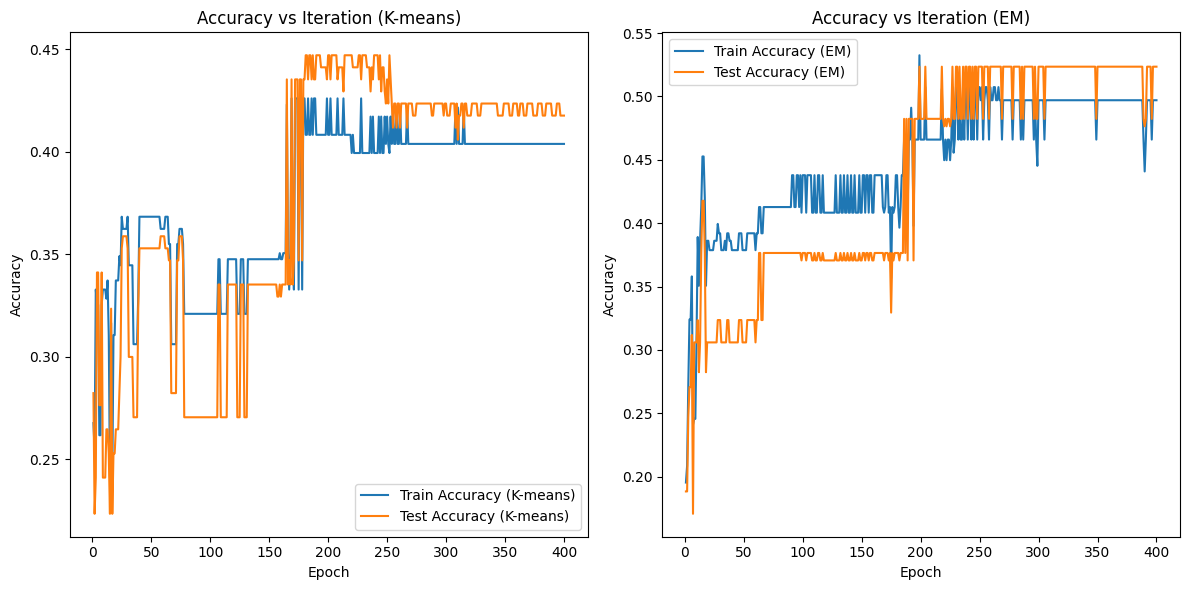

Best test accuracy for K-means is 0.4470588235294118
Best test accuracy for EM is 0.5235294117647059


In [18]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import fetch_openml
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import time
import matplotlib.pyplot as plt

# Check for GPU availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load the Statlog dataset (replace 'statlog_dataset.csv' with your dataset file)
data = fetch_openml("vehicle")

# Extract the features and labels
X = data.data
y = data.target

# Convert target labels to numeric format
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Perform K-means clustering and EM (Expectation-Maximization) clustering
n_clusters = 12  # Number of clusters for K-means and EM

# Create K-means and EM clustering models
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
em = GaussianMixture(n_components=n_clusters, random_state=42)

# Fit K-means and EM clustering models to the training data
# Fit K-means and EM clustering models to the training data
X_train_kmeans = kmeans.fit_predict(X_train).reshape(-1, 1)
X_test_kmeans = kmeans.predict(X_test).reshape(-1, 1)

X_train_em = em.fit(X_train).predict(X_train).reshape(-1, 1)
X_test_em = em.predict(X_test).reshape(-1, 1)

# Create two neural network models for K-means and EM features
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, num_classes):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Specify the number of classes in your dataset
num_classes = len(np.unique(y))

# Create neural network models for K-means and EM features
model_kmeans = NeuralNetwork(X_train_kmeans.shape[1], num_classes).to(device)
model_em = NeuralNetwork(X_train_em.shape[1], num_classes).to(device)

# Define loss function and optimizer for multi-class classification
criterion = nn.CrossEntropyLoss()
optimizer_kmeans = optim.Adam(model_kmeans.parameters(), lr=0.001, weight_decay=0.0001)
optimizer_em = optim.Adam(model_em.parameters(), lr=0.001, weight_decay=0.0001)

# Convert NumPy arrays to PyTorch tensors
X_train_kmeans = torch.tensor(X_train_kmeans, dtype=torch.float32).to(device)
X_train_em = torch.tensor(X_train_em, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)

# Lists to store training and test accuracies for K-means and EM
train_accuracies_kmeans = []
test_accuracies_kmeans = []
train_accuracies_em = []
test_accuracies_em = []

# Train the models for K-means and EM features
num_epochs = 400
for epoch in range(num_epochs):
    model_kmeans.train()
    optimizer_kmeans.zero_grad()
    
    outputs_kmeans = model_kmeans(X_train_kmeans)
    loss_kmeans = criterion(outputs_kmeans, y_train)
    loss_kmeans.backward()
    optimizer_kmeans.step()
    
    model_em.train()
    optimizer_em.zero_grad()
    outputs_em = model_em(X_train_em)
    loss_em = criterion(outputs_em, y_train)
    loss_em.backward()
    optimizer_em.step()

    # Evaluate the models on the test data
    model_kmeans.eval()
    model_em.eval()

    with torch.no_grad():
        outputs_kmeans = model_kmeans(X_train_kmeans)
        predictions_kmeans = torch.argmax(outputs_kmeans, dim=1)
        train_accuracies_kmeans.append(accuracy_score(y_train.cpu().numpy(), predictions_kmeans.cpu().numpy()))

        outputs_em = model_em(X_train_em)
        predictions_em = torch.argmax(outputs_em, dim=1)
        train_accuracies_em.append(accuracy_score(y_train.cpu().numpy(), predictions_em.cpu().numpy()))

        outputs_kmeans = model_kmeans(torch.tensor(X_test_kmeans, dtype=torch.float32).to(device))
        predictions_kmeans = torch.argmax(outputs_kmeans, dim=1)
        test_accuracies_kmeans.append(accuracy_score(y_test, predictions_kmeans.cpu().numpy()))

        outputs_em = model_em(torch.tensor(X_test_em, dtype=torch.float32).to(device))
        predictions_em = torch.argmax(outputs_em, dim=1)
        test_accuracies_em.append(accuracy_score(y_test, predictions_em.cpu().numpy()))

# Plot the time vs iteration
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_accuracies_kmeans, label="Train Accuracy (K-means)")
plt.plot(range(1, num_epochs + 1), test_accuracies_kmeans, label="Test Accuracy (K-means)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Iteration (K-means)")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies_em, label="Train Accuracy (EM)")
plt.plot(range(1, num_epochs + 1), test_accuracies_em, label="Test Accuracy (EM)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Iteration (EM)")
plt.legend()

plt.tight_layout()
plt.show()

print("Best test accuracy for K-means is", max(test_accuracies_kmeans))
print("Best test accuracy for EM is", max(test_accuracies_em))


/home/kh/app/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


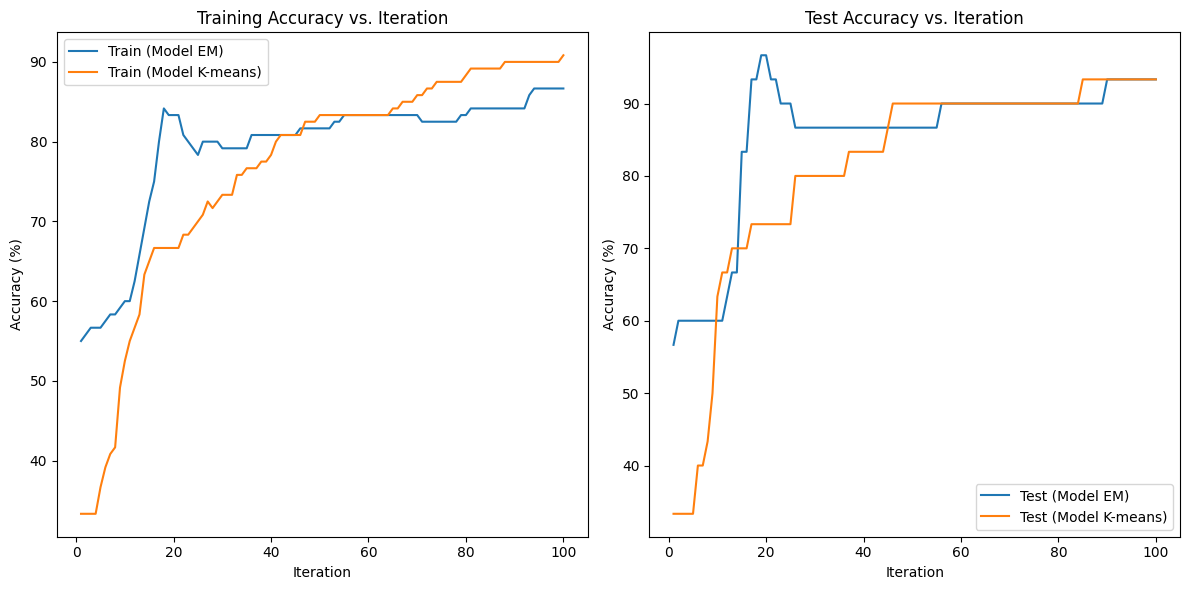

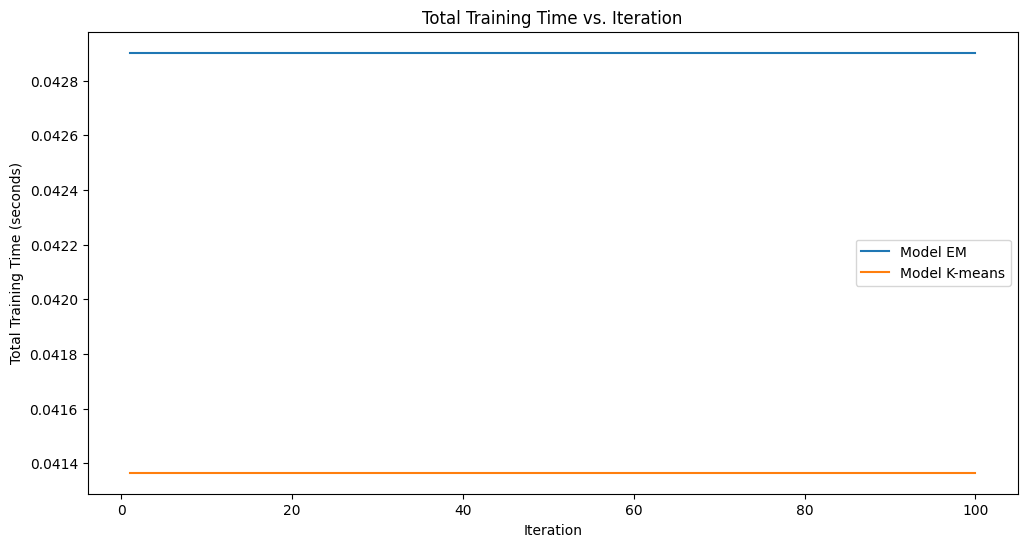

Total training time (Model EM): 0.04290199279785156 seconds
Total training time (Model K-means): 0.041365623474121094 seconds


In [25]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load the Statlog dataset (replace with your dataset loading code)
data = load_iris()
X = data.data
y = data.target

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Perform EM clustering
n_clusters_em = 3  # Replace with your desired number of clusters
em = GaussianMixture(n_components=n_clusters_em, random_state=0)
em_clusters = em.fit_predict(X_train)

# Perform K-means clustering
n_clusters_kmeans = 3  # Replace with your desired number of clusters
kmeans = KMeans(n_clusters=n_clusters_kmeans, random_state=0)
kmeans_clusters = kmeans.fit_predict(X_train)

# Define the neural network architecture
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Define hyperparameters
input_dim_em = X_train.shape[1]
input_dim_kmeans = X_train.shape[1]
hidden_dim = 64
output_dim = len(np.unique(y))

# Create and train the neural network for EM clusters
model_em = NeuralNetwork(input_dim_em, hidden_dim, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer_em = optim.Adam(model_em.parameters(), lr=0.001)

X_train_em_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)

# Lists to store training statistics for EM clusters
iterations_em = []
train_accuracy_em = []
test_accuracy_em = []

start_time_em = time.time()

for epoch in range(100):
    optimizer_em.zero_grad()
    outputs_em = model_em(X_train_em_tensor)
    loss_em = criterion(outputs_em, y_train_tensor)
    loss_em.backward()
    optimizer_em.step()

    # Calculate and store training accuracy
    model_em.eval()
    with torch.no_grad():
        outputs_em_train = model_em(X_train_em_tensor)
        predicted_em_train = torch.argmax(outputs_em_train, dim=1).numpy()
        correct_train_em = (predicted_em_train == y_train).sum()
        train_acc_em = correct_train_em / len(y_train) * 100
        train_accuracy_em.append(train_acc_em)

    # Calculate and store test accuracy
    model_em.eval()
    with torch.no_grad():
        X_test_em_tensor = torch.FloatTensor(X_test)
        outputs_em_test = model_em(X_test_em_tensor)
        predicted_em_test = torch.argmax(outputs_em_test, dim=1).numpy()
        correct_test_em = (predicted_em_test == y_test).sum()
        test_acc_em = correct_test_em / len(y_test) * 100
        test_accuracy_em.append(test_acc_em)

    iterations_em.append(epoch + 1)

end_time_em = time.time()

# Create and train the neural network for K-means clusters
model_kmeans = NeuralNetwork(input_dim_kmeans, hidden_dim, output_dim)
optimizer_kmeans = optim.Adam(model_kmeans.parameters(), lr=0.001)

X_train_kmeans_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)

# Lists to store training statistics for K-means clusters
iterations_kmeans = []
train_accuracy_kmeans = []
test_accuracy_kmeans = []

start_time_kmeans = time.time()

for epoch in range(100):
    optimizer_kmeans.zero_grad()
    outputs_kmeans = model_kmeans(X_train_kmeans_tensor)
    loss_kmeans = criterion(outputs_kmeans, y_train_tensor)
    loss_kmeans.backward()
    optimizer_kmeans.step()

    # Calculate and store training accuracy
    model_kmeans.eval()
    with torch.no_grad():
        outputs_kmeans_train = model_kmeans(X_train_kmeans_tensor)
        predicted_kmeans_train = torch.argmax(outputs_kmeans_train, dim=1).numpy()
        correct_train_kmeans = (predicted_kmeans_train == y_train).sum()
        train_acc_kmeans = correct_train_kmeans / len(y_train) * 100
        train_accuracy_kmeans.append(train_acc_kmeans)

    # Calculate and store test accuracy
    model_kmeans.eval()
    with torch.no_grad():
        X_test_kmeans_tensor = torch.FloatTensor(X_test)
        outputs_kmeans_test = model_kmeans(X_test_kmeans_tensor)
        predicted_kmeans_test = torch.argmax(outputs_kmeans_test, dim=1).numpy()
        correct_test_kmeans = (predicted_kmeans_test == y_test).sum()
        test_acc_kmeans = correct_test_kmeans / len(y_test) * 100
        test_accuracy_kmeans.append(test_acc_kmeans)

    iterations_kmeans.append(epoch + 1)

end_time_kmeans = time.time()

# Calculate total training times
total_time_em = end_time_em - start_time_em
total_time_kmeans = end_time_kmeans - start_time_kmeans

# Plot training and test accuracy vs. iteration for both models
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(iterations_em, train_accuracy_em, label="Train (Model EM)")
plt.plot(iterations_kmeans, train_accuracy_kmeans, label="Train (Model K-means)")
plt.xlabel("Iteration")
plt.ylabel("Accuracy (%)")
plt.title("Training Accuracy vs. Iteration")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(iterations_em, test_accuracy_em, label="Test (Model EM)")
plt.plot(iterations_kmeans, test_accuracy_kmeans, label="Test (Model K-means)")
plt.xlabel("Iteration")
plt.ylabel("Accuracy (%)")
plt.title("Test Accuracy vs. Iteration")
plt.legend()

plt.tight_layout()

# Plot total time vs. iteration for both models
plt.figure(figsize=(12, 6))
plt.plot(iterations_em, [end_time_em - start_time_em for _ in range(len(iterations_em))], label="Model EM")
plt.plot(iterations_kmeans, [end_time_kmeans - start_time_kmeans for _ in range(len(iterations_kmeans))], label="Model K-means")
plt.xlabel("Iteration")
plt.ylabel("Total Training Time (seconds)")
plt.title("Total Training Time vs. Iteration")
plt.legend()

plt.show()

print(f"Total training time (Model EM): {total_time_em} seconds")
print(f"Total training time (Model K-means): {total_time_kmeans} seconds")
